In [37]:
import sys

In [38]:
print(sys.executable)

/cvmfs/jupyter.hpc.rwth.de/clients/python311-c23/bin/python


In [39]:
sys.path.append('/home/bh774267/.local/lib/python3.11/site-packages')

In [8]:
!pip install --user torch torchvision

  Using cached torch-2.9.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (30 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached fsspec-2025.10.0-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvi

In [4]:
!pip install --user Pillow

In [28]:
!pip install --user ptflops

  Using cached ptflops-0.7.5-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cusolver_cu12-11.7.3.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cusparse_cu12-12.5.8.93-py3-none-manylinux2014_

In [40]:
import torch
import pennylane as qml

In [41]:
import matplotlib.pyplot as plt

In [42]:
import numpy as np
import pandas as pd
import os

In [43]:
import torch.nn as nn

In [44]:
import torchvision

In [45]:
import torch.nn.functional as F

In [46]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import time
from sklearn.metrics import f1_score, precision_score, recall_score
from PIL import Image
from ptflops import get_model_complexity_info

In [47]:
# Constants
I0 = 1.0  # peak intensity

# Parameters
img_width = 256           # pixels across x
img_height = 64           # vertical height for visualization
output_dir = "double_slit_images"
metadata_dir = "double_slit_metadata"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(metadata_dir, exist_ok=True)
x = np.linspace(-10e-3, 10e-3, img_width)  # screen positions

# Simulation Parameters
num_samples = 10000
num_points = 100      # number of x points per pattern
#x = np.linspace(-10e-3, 10e-3, num_points)  # screen positions in meters

# Define parameter ranges
d_range = (0.1e-3, 1.0e-3)   # slit separation [m]
a_range = (0.02e-3, 0.2e-3)  # slit width [m]
λ_range = (400e-9, 700e-9)   # wavelength [m]
L_range = (0.5, 2.0)         # distance to screen [m]

In [48]:
print(0.1e-3/350e-9)

285.7142857142857


In [49]:

def double_slit_intensity(x, d, a, λ, L, I0=1.0):
    beta = (np.pi * d * x) / (λ * L)
    alpha = (np.pi * a * x) / (λ * L)
    sinc = np.sinc(alpha / np.pi)  # np.sinc uses sin(pi*x)/(pi*x)
    I = I0 * (np.cos(beta)**2) * (sinc**2)
    return I / np.max(I)  # normalize to [0, 1]

# Define the 8 thresholds for the d/λ ratio (Based on range ~143 to 2500)
# These define the boundaries between classes 0, 1, 2, ..., 7
THRESHOLDS = [438, 1028, 1618, 2208]
#THRESHOLDS = [400e-9, 450e-9, 500e-9, 550e-9, 600e-9, 650e-9, 700e-9]
#THRESHOLDS = [438, 1028, 1913]
NOISE_STD_DEV = 0.1 # Standard deviation for Gaussian Noise (Recommended for robustness)

# Data generation loop
metadata = []

for i in range(num_samples):
    d = np.random.uniform(*d_range)
    a = np.random.uniform(*a_range)
    λ = np.random.uniform(*λ_range)
    L = np.random.uniform(*L_range)

    # 2. Calculate Intensity
    I_x = double_slit_intensity(x, d, a, λ, L, I0)
    #print("Inetensity data", I_x)
    img = np.tile(I_x, (img_height, 1))

    # 3. Add Gaussian Noise and Clip (Optional but recommended)
    noise = np.random.normal(0.0, NOISE_STD_DEV, img.shape)
    noisy_img = img + noise
    img_to_save = np.clip(noisy_img, 0.0, 1.0) # Ensure values stay within [0, 1]

    # 4. Calculate Ratio and Determine Class (The core classification logic)
    d_lambda_ratio = d / λ
   # class_label = "7" # Default to the highest class
    class_label = str(len(THRESHOLDS))
    # Assign class based on which threshold interval λ falls into
    for j, threshold in enumerate(THRESHOLDS):
        if d_lambda_ratio < threshold:
            class_label = str(j)
            break
        
    # 5. Create the class folder structure
    class_output_dir = os.path.join(output_dir, class_label)
    os.makedirs(class_output_dir, exist_ok=True)
    
    # 6. Save image into the correct class folder
    filename = f"pattern_{i:04d}.png"
    img_to_save = img_to_save.astype(np.float32)

    

    img_pil = Image.fromarray((img_to_save * 255).astype(np.uint8), mode='L') 
    
    img_pil.save(os.path.join(class_output_dir, filename))
    
    # plt.imsave(os.path.join(class_output_dir, filename), img_to_save, vmin=0, vmax=1)
    
    # 7. Append metadata (include the assigned class for verification)
    metadata.append([filename, d, a, λ, L, d_lambda_ratio, class_label])


# Save Metadata (Updated columns)
metadata_df = pd.DataFrame(metadata, columns=["filename", "d", "a", "lambda", "L", "d_lambda_ratio", "class"])
metadata_df.to_csv(os.path.join(metadata_dir, "metadata.csv"), index=False)

print(f"Generated {num_samples} patterns, distributed into 4 class folders (0-3) in '{output_dir}/'")

# NOTE: You must now use torchvision.datasets.ImageFolder("double_slit_images", ...) 
# The ImageFolder function will automatically assign the folder name ('0' to '7') as the class label.



Generated 10000 patterns, distributed into 4 class folders (0-3) in 'double_slit_images/'


In [53]:
from PIL import Image
import numpy as np

img = Image.open("double_slit_images/0/pattern_0000.png")
print(np.array(img).shape)

(64, 256)


In [54]:
metadata_df = pd.read_csv("double_slit_metadata/metadata.csv")

# Filter rows where class == "0"
class0 = metadata_df[metadata_df["class"] == "0"]

# Now check that all wavelengths are between 400–450 nm
assert class0["lambda"].between(350e-9, 450e-9).all()

In [19]:
"""
import os
import shutil

# Folder where your images currently are
source_folder = "jupyterlab"

# Name of the subfolder to create
subfolder_name = "intensities"
target_folder = os.path.join(source_folder, subfolder_name)

# Create the subfolder if it doesn't exist
os.makedirs(target_folder, exist_ok=True)

# Move all .png files into the subfolder
for file_name in os.listdir(source_folder):
    if file_name.lower().endswith('.png'):
        full_source_path = os.path.join(source_folder, file_name)
        full_target_path = os.path.join(target_folder, file_name)

        # Make sure it's a file (not a directory)
        if os.path.isfile(full_source_path):
            shutil.move(full_source_path, full_target_path)

print(f"Moved all .png files from '{source_folder}' to '{target_folder}'")
"""

Moved all .png files from 'jupyterlab' to 'jupyterlab/intensities'


In [55]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    #AddGaussianNoise(mean=0.0, std=0.1),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = datasets.ImageFolder("double_slit_images", transform=transform)

#train_df, test_df = train_test_split(dataset, test_size=0.3, stratify= dataset['class'], random_state=42, shuffle=True)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader_split = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = 4)
testloader_split = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


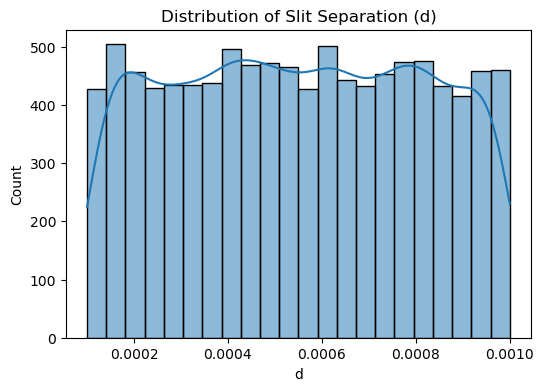

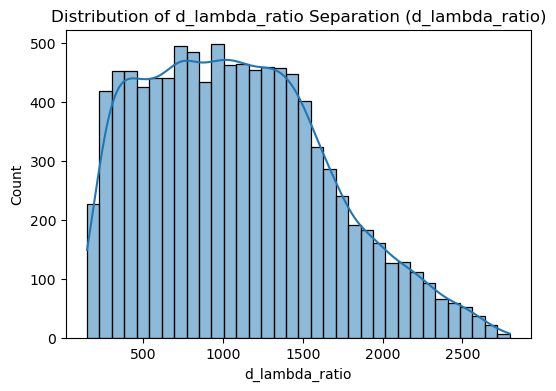

"\n# Crucial Check: Diversity of Slit Width (a) within each Wavelength Class\nplt.figure(figsize=(10, 6))\nsns.boxplot(x='class', y='I_x', data=metadata_df)\nplt.title('Slit Width (a) Distribution Across intensity ratio Classes')\nplt.ylabel('Slit Width (a) [m]')\nplt.xlabel('Wavelength Class Index')\nplt.show()\n"

In [17]:
# Assuming you have loaded your metadata_df
import seaborn as sns
import matplotlib.pyplot as plt
# metadata_df = pd.read_csv(os.path.join(metadata_dir, "metadata.csv")) 

# Check the distribution of slit separation (d) across ALL samples
plt.figure(figsize=(6, 4))
sns.histplot(metadata_df['d'], kde=True)
plt.title('Distribution of Slit Separation (d)')
plt.show()

# Check the distribution of intensity (I_x) across ALL samples
plt.figure(figsize=(6, 4))
sns.histplot(metadata_df['d_lambda_ratio'], kde=True)
plt.title('Distribution of d_lambda_ratio Separation (d_lambda_ratio)')
plt.show()

"""
# Crucial Check: Diversity of Slit Width (a) within each Wavelength Class
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='I_x', data=metadata_df)
plt.title('Slit Width (a) Distribution Across intensity ratio Classes')
plt.ylabel('Slit Width (a) [m]')
plt.xlabel('Wavelength Class Index')
plt.show()
"""

In [33]:
data_iter = iter(trainloader_split)
images, labels = next(data_iter) 
# Check the labels here before sending to GPU
print(f"Labels dtype: {labels.dtype}") # Must be torch.int64 (Long)
print(f"Labels max value: {labels.max()}") # Must be <= 7
print(f"Labels min value: {labels.min()}")

print(labels.min().item(), labels.max().item())

Labels dtype: torch.int64
Labels max value: 3
Labels min value: 0
0 3


In [16]:
print(outputs.shape)  # should be [batch_size, num_classes]
print(labels.shape)  

NameError: name 'outputs' is not defined

In [56]:
print(dataset.classes)        # list of class names
print(len(dataset.classes))  

['0', '1', '2', '3', '4']
5


In [20]:
class CNN(nn.Module):
    def __init__(self,num_classes):
        super(CNN, self).__init__()

        # Input: 1 x 64 x 64 (for example)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial dims by half

        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # assuming input was 64x64
        self.fc2 = nn.Linear(128,5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [B, 16, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # -> [B, 32, 16, 16]
        x = self.pool(F.relu(self.conv3(x)))  # -> [B, 64, 8, 8]

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [21]:
print(dataset.classes)
print(dataset.class_to_idx)

['0', '1', '2', '3', '4']
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


In [55]:
features, labels = next(iter(trainloader_split))
features, labels = features.to(device), labels.to(device)
outputs = model(features)
print(outputs.shape) 

AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [23]:
features, labels = next(iter(trainloader_split))
features, labels = features.to(device), labels.to(device)

outputs = model(features)
print("Outputs shape:", outputs.shape)   # [B, 7]
print("Labels dtype:", labels.dtype)     # should be torch.int64
print("Labels shape:", labels.shape)     # [B]
print("Labels range:", labels.min().item(), labels.max().item())


NameError: name 'device' is not defined

In [31]:
print("------Running on CPU ------")
device = torch.device("cpu")

model = CNN(num_classes=4).to(device)  # move model to CPU

features, labels = next(iter(trainloader_split))
features, labels = features.to(device), labels.to(device)

outputs = model(features)
print(outputs.shape)

------Running on CPU ------
torch.Size([32, 5])


In [97]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(num_classes=len(dataset.classes)).to(device)

features, labels = next(iter(trainloader_split))
features, labels = features.to(device), labels.to(device)

outputs = model(features)
print(outputs.shape)  # should be [32, 7]

torch.Size([32, 5])


In [60]:
print(trainloader_split)

In [23]:
def sanity_check(dataset, model, trainloader):
    """
    Verify dataset and model alignment before training.
    - Checks number of classes in dataset
    - Checks model output size
    - Checks label ranges
    """

    # 1. Dataset classes
    num_classes_dataset = len(dataset.classes)
    print(f"Dataset reports {num_classes_dataset} classes: {dataset.classes}")

    # 2. Model output size
    features, labels = next(iter(trainloader))
    features, labels = features.to(next(model.parameters()).device), labels.to(next(model.parameters()).device)
    outputs = model(features)
    num_classes_model = outputs.shape[1]
    print(f"Model outputs {num_classes_model} classes")

    # 3. Label range
    min_label, max_label = labels.min().item(), labels.max().item()
    print(f"Labels in batch range from {min_label} to {max_label}")

    # 4. Assertions
    assert num_classes_dataset == num_classes_model, \
        f"Mismatch: dataset has {num_classes_dataset} classes but model outputs {num_classes_model}"
    assert min_label >= 0 and max_label < num_classes_model, \
        f"Invalid labels: found {min_label}–{max_label}, but model only supports 0–{num_classes_model-1}"

    print("✅ Sanity check passed: dataset and model are aligned!")


In [25]:
features, labels = next(iter(trainloader_split))

print("Labels batch:", labels)
print("Label min:", labels.min().item(), "Label max:", labels.max().item())
print("Num classes in dataset:", len(dataset.classes))

Labels batch: tensor([2, 2, 2, 2, 2, 3, 0, 4, 3, 0, 1, 3, 2, 1, 2, 3, 1, 2, 2, 2, 2, 1, 0, 0,
        2, 0, 3, 1, 4, 2, 2, 0])
Label min: 0 Label max: 4
Num classes in dataset: 5


In [24]:
sanity_check(dataset, model, trainloader_split)

Dataset reports 5 classes: ['0', '1', '2', '3', '4']
Model outputs 5 classes
Labels in batch range from 0 to 4
✅ Sanity check passed: dataset and model are aligned!


In [28]:

#CNN Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

model = CNN(num_classes=8).to(device)
#Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



# History lists for plotting
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
test_f1_history = [] 
epoch_time =[]

loss_bench = 0
n_epochs = 50


if device.type == 'cuda':
    # Reset memory stats and check before training starts
    torch.cuda.reset_peak_memory_stats(device)
    initial_memory = torch.cuda.max_memory_allocated(device)
    print(f"GPU Memory Initial State: {initial_memory / 1024**2:.2f} MB")



def cnn_test(model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in testloader_split:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            
            # Calculate and accumulate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
        avg_loss = running_loss / len(testloader_split)
        accuracy = correct / len(testloader_split.dataset)
        
    # Calculate macro-averaged metrics
    # Note: Scikit-learn requires non-empty lists, which is guaranteed here
    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1

## --- Training Loop ---
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in trainloader_split:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Calculate Training Metrics
    train_avg_loss = running_loss / len(trainloader_split)
    train_accuracy = correct / len(trainloader_split.dataset)
    
    # Store Training History
    train_loss_history.append(train_avg_loss)
    train_acc_history.append(train_accuracy*100)
    
    # Evaluate on Test Set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = cnn_test(model, criterion, device)
    
    # Store Test History
    test_loss_history.append(val_loss)
    test_acc_history.append(val_accuracy*100)
    test_f1_history.append(val_f1) # Example of tracking
    
    
    epoch_duration = end_time - start_time
    epoch_time.append(epoch_duration)
    
    # Print Epoch Summary 
    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_avg_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f} | "
          f"Time: {epoch_duration:.2f}s")
    
    if epoch == 0 and device.type == 'cuda':
        peak_memory = torch.cuda.max_memory_allocated(device)
        print(f"GPU Peak Memory Used: {(peak_memory - initial_memory) / 1024**2:.2f} MB")
"""
macs, params = get_model_complexity_info(model,trainloader_split, as_strings=True, print_per_layer_stat=True, verbose=True)
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")
"""

GPU Memory Initial State: 73.16 MB
Epoch 01: Train Loss: 1.0278, Train Acc: 0.5441 | Test Loss: 0.9100, Test Acc: 0.5855 | Precision: 0.4877, Recall: 0.5061, F1: 0.4888 | Time: 54.39s
GPU Peak Memory Used: 37.42 MB


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 02: Train Loss: 0.9005, Train Acc: 0.5894 | Test Loss: 0.8904, Test Acc: 0.5925 | Precision: 0.4977, Recall: 0.5152, F1: 0.4920 | Time: 44.01s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 03: Train Loss: 0.8807, Train Acc: 0.5947 | Test Loss: 0.8543, Test Acc: 0.6083 | Precision: 0.5118, Recall: 0.5280, F1: 0.5078 | Time: 31.30s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 04: Train Loss: 0.8657, Train Acc: 0.5959 | Test Loss: 0.8460, Test Acc: 0.6085 | Precision: 0.5098, Recall: 0.5290, F1: 0.5074 | Time: 30.71s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 05: Train Loss: 0.8603, Train Acc: 0.5946 | Test Loss: 0.8503, Test Acc: 0.6060 | Precision: 0.7080, Recall: 0.5247, F1: 0.5085 | Time: 24.08s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 06: Train Loss: 0.8540, Train Acc: 0.5987 | Test Loss: 0.8469, Test Acc: 0.5989 | Precision: 0.6509, Recall: 0.5033, F1: 0.4905 | Time: 20.27s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 07: Train Loss: 0.8500, Train Acc: 0.5980 | Test Loss: 0.8552, Test Acc: 0.5988 | Precision: 0.5137, Recall: 0.5276, F1: 0.4895 | Time: 19.37s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 08: Train Loss: 0.8462, Train Acc: 0.5989 | Test Loss: 0.8301, Test Acc: 0.6127 | Precision: 0.6385, Recall: 0.5312, F1: 0.5184 | Time: 20.31s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 09: Train Loss: 0.8429, Train Acc: 0.6019 | Test Loss: 0.8278, Test Acc: 0.6142 | Precision: 0.6325, Recall: 0.5328, F1: 0.5226 | Time: 21.36s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Train Loss: 0.8405, Train Acc: 0.6022 | Test Loss: 0.8323, Test Acc: 0.6113 | Precision: 0.5653, Recall: 0.5307, F1: 0.5247 | Time: 35.45s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Train Loss: 0.8379, Train Acc: 0.6072 | Test Loss: 0.8267, Test Acc: 0.6142 | Precision: 0.6337, Recall: 0.5288, F1: 0.5211 | Time: 39.47s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Train Loss: 0.8336, Train Acc: 0.6065 | Test Loss: 0.8342, Test Acc: 0.6060 | Precision: 0.6700, Recall: 0.5378, F1: 0.5106 | Time: 38.36s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Train Loss: 0.8338, Train Acc: 0.6050 | Test Loss: 0.8258, Test Acc: 0.6054 | Precision: 0.6065, Recall: 0.5173, F1: 0.5175 | Time: 38.25s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Train Loss: 0.8320, Train Acc: 0.6079 | Test Loss: 0.8252, Test Acc: 0.6055 | Precision: 0.5982, Recall: 0.5142, F1: 0.5117 | Time: 28.74s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Train Loss: 0.8287, Train Acc: 0.6102 | Test Loss: 0.8306, Test Acc: 0.6073 | Precision: 0.6166, Recall: 0.5147, F1: 0.5101 | Time: 30.93s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Train Loss: 0.8281, Train Acc: 0.6083 | Test Loss: 0.8173, Test Acc: 0.6181 | Precision: 0.6159, Recall: 0.5451, F1: 0.5343 | Time: 25.98s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Train Loss: 0.8270, Train Acc: 0.6084 | Test Loss: 0.8173, Test Acc: 0.6099 | Precision: 0.6479, Recall: 0.5161, F1: 0.5142 | Time: 23.80s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Train Loss: 0.8243, Train Acc: 0.6078 | Test Loss: 0.8174, Test Acc: 0.6195 | Precision: 0.6613, Recall: 0.5379, F1: 0.5323 | Time: 36.33s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Train Loss: 0.8235, Train Acc: 0.6099 | Test Loss: 0.8204, Test Acc: 0.6157 | Precision: 0.6656, Recall: 0.5359, F1: 0.5247 | Time: 34.73s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Train Loss: 0.8222, Train Acc: 0.6097 | Test Loss: 0.8177, Test Acc: 0.6136 | Precision: 0.6322, Recall: 0.5280, F1: 0.5252 | Time: 32.98s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Train Loss: 0.8214, Train Acc: 0.6084 | Test Loss: 0.8162, Test Acc: 0.6165 | Precision: 0.6063, Recall: 0.5383, F1: 0.5345 | Time: 38.42s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Train Loss: 0.8204, Train Acc: 0.6095 | Test Loss: 0.8203, Test Acc: 0.6124 | Precision: 0.6133, Recall: 0.5289, F1: 0.5277 | Time: 39.81s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Train Loss: 0.8194, Train Acc: 0.6100 | Test Loss: 0.8203, Test Acc: 0.6145 | Precision: 0.5898, Recall: 0.5418, F1: 0.5346 | Time: 43.63s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Train Loss: 0.8198, Train Acc: 0.6112 | Test Loss: 0.8123, Test Acc: 0.6195 | Precision: 0.6597, Recall: 0.5362, F1: 0.5317 | Time: 42.75s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Train Loss: 0.8184, Train Acc: 0.6107 | Test Loss: 0.8150, Test Acc: 0.6157 | Precision: 0.6363, Recall: 0.5338, F1: 0.5311 | Time: 43.27s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Train Loss: 0.8175, Train Acc: 0.6111 | Test Loss: 0.8176, Test Acc: 0.6161 | Precision: 0.6418, Recall: 0.5422, F1: 0.5336 | Time: 35.86s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Train Loss: 0.8165, Train Acc: 0.6111 | Test Loss: 0.8158, Test Acc: 0.6101 | Precision: 0.5941, Recall: 0.5244, F1: 0.5244 | Time: 43.50s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Train Loss: 0.8162, Train Acc: 0.6120 | Test Loss: 0.8115, Test Acc: 0.6187 | Precision: 0.6469, Recall: 0.5328, F1: 0.5314 | Time: 38.20s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Train Loss: 0.8148, Train Acc: 0.6142 | Test Loss: 0.8153, Test Acc: 0.6176 | Precision: 0.6400, Recall: 0.5445, F1: 0.5324 | Time: 41.37s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Train Loss: 0.8148, Train Acc: 0.6154 | Test Loss: 0.8135, Test Acc: 0.6196 | Precision: 0.6721, Recall: 0.5452, F1: 0.5332 | Time: 38.89s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Train Loss: 0.8139, Train Acc: 0.6131 | Test Loss: 0.8118, Test Acc: 0.6173 | Precision: 0.6610, Recall: 0.5452, F1: 0.5304 | Time: 32.49s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Train Loss: 0.8141, Train Acc: 0.6114 | Test Loss: 0.8114, Test Acc: 0.6203 | Precision: 0.6637, Recall: 0.5471, F1: 0.5343 | Time: 29.75s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Train Loss: 0.8119, Train Acc: 0.6154 | Test Loss: 0.8106, Test Acc: 0.6117 | Precision: 0.6478, Recall: 0.5268, F1: 0.5260 | Time: 29.12s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Train Loss: 0.8118, Train Acc: 0.6114 | Test Loss: 0.8097, Test Acc: 0.6158 | Precision: 0.5890, Recall: 0.5374, F1: 0.5348 | Time: 75.06s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Train Loss: 0.8119, Train Acc: 0.6148 | Test Loss: 0.8145, Test Acc: 0.6136 | Precision: 0.5800, Recall: 0.5315, F1: 0.5329 | Time: 66.87s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Train Loss: 0.8105, Train Acc: 0.6146 | Test Loss: 0.8133, Test Acc: 0.6177 | Precision: 0.6637, Recall: 0.5412, F1: 0.5332 | Time: 58.64s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Train Loss: 0.8110, Train Acc: 0.6137 | Test Loss: 0.8135, Test Acc: 0.6201 | Precision: 0.6026, Recall: 0.5478, F1: 0.5413 | Time: 53.79s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

In [27]:
inputs, _ = next(iter(trainloader_split))
input_res = tuple(inputs.shape[1:])  # drop batch dimension

macs, params = get_model_complexity_info(
    model,
    input_res,
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True
)

CNN(
  548.36 k, 100.000% Params, 10.78 MMac, 97.916% MACs, 
  (conv1): Conv2d(160, 0.029% Params, 655.36 KMac, 5.952% MACs, 1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4.64 k, 0.846% Params, 4.75 MMac, 43.151% MACs, 16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(18.5 k, 3.373% Params, 4.73 MMac, 43.002% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(0, 0.000% Params, 114.69 KMac, 1.042% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(524.42 k, 95.634% Params, 524.42 KMac, 4.763% MACs, in_features=4096, out_features=128, bias=True)
  (fc2): Linear(645, 0.118% Params, 645.0 Mac, 0.006% MACs, in_features=128, out_features=5, bias=True)
)


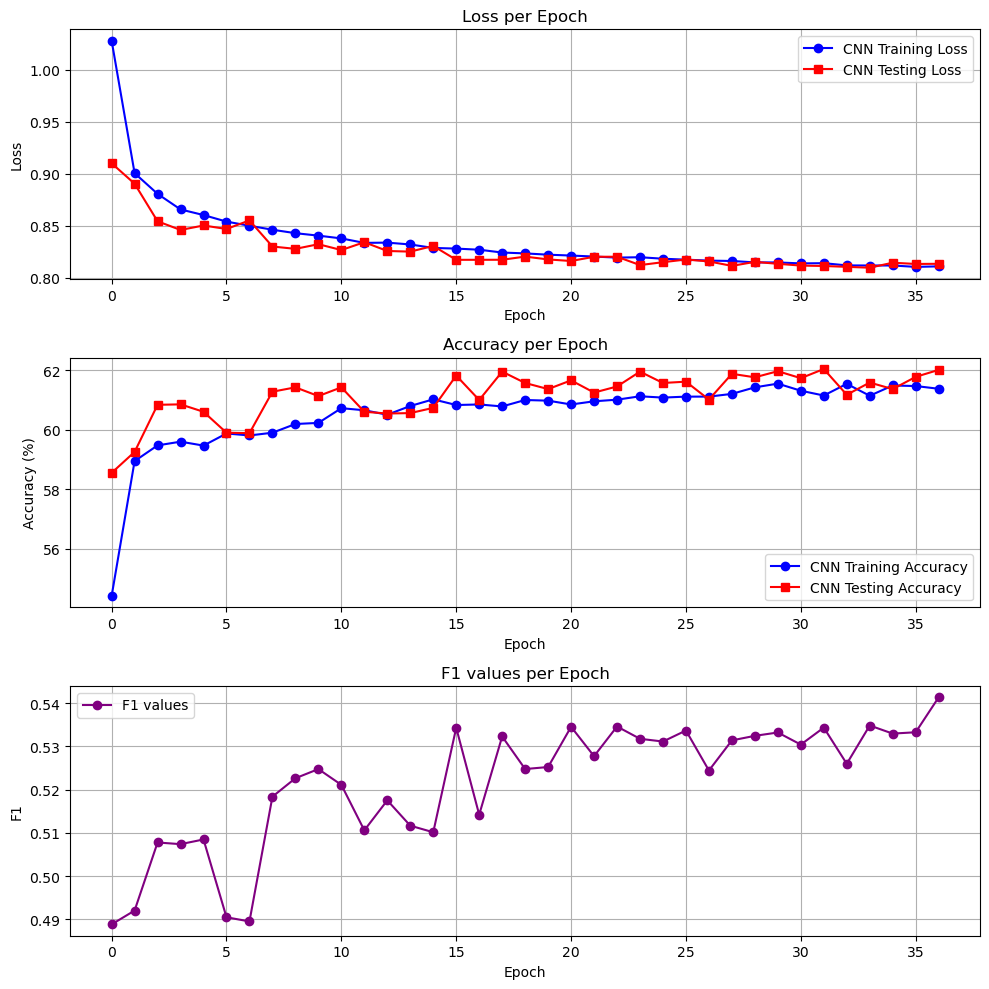

In [29]:

import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(3, 1,1)
plt.plot(train_loss_history, marker='o', label='CNN Training Loss', color='blue')
plt.plot(test_loss_history,marker='s', label='CNN Testing Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(3, 1, 2)
plt.plot(train_acc_history, marker= 'o', label='CNN Training Accuracy', color= 'blue')
plt.plot(test_acc_history,marker= 's', label= 'CNN Testing Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(test_f1_history, marker= 'o', label='F1 values', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid(True)
plt.legend()

"""
plt.subplot(3, 2, 1)
plt.plot(epoch_duration, marker= 'o', label='Elapsed time per Epoch', color= 'orange')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Elapsed time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time')
plt.grid(True)
plt.legend()
"""

plt.tight_layout()
#plt.savefig('double_slit_cnn_1Channel_10000Samples_d_lambda_Ratio.png')
plt.show()

In [57]:
import pennylane as qml
import os
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.func import vmap

In [64]:
#AutoEncoder Class

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims=8):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(1*64*64, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(f"Input:{x.shape}")
        x = torch.flatten(x, start_dim=1)
        #print(f"After conv1: {x.shape}")
        x = F.relu(self.linear1(x))
        #print(f"After conv2: {x.shape}")
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        #print(f"Output (Latent): {x.shape}")
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 64 * 16 * 16)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
    def forward(self, x):
        #print(f"Input (Latent): {x.shape}")
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        #print(f"After fc2: {x.shape}")
        x = x.view(-1, 64, 16, 16)
        #print(f"After view: {x.shape}")
        x = torch.relu(self.deconv1(x))
        #print(f"After deconv1: {x.shape}")
        x = torch.relu(self.deconv2(x))
        #print(f"After deconv2: {x.shape}")
        x = torch.sigmoid(self.deconv3(x))
        #print(f"Output (Reconstruction): {x.shape}")
        return x


In [65]:
dev = qml.device("default.qubit", wires=10)

In [66]:
# QCNN layer
def qcnn_block(weights,wires):
    for w in range(wires):
        qml.Hadamard(w)
    #qml.Toffoli(wires=[0,2,4])
    # Convolution Layer 1
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[0], wires=1)
    qml.CNOT(wires=[2, 3])
    qml.RZ(weights[2], wires=3)
    qml.CNOT(wires=[4, 5])
    qml.RZ(weights[4], wires=5)
    qml.CNOT(wires=[6, 7])
    qml.RZ(weights[6], wires=7)
    qml.CNOT(wires=[8, 9])
    qml.RZ(weights[8], wires=9)
    
    # Pooling Layer 1
    qml.CNOT(wires=[1, 0])
    qml.RY(weights[1], wires=0)  # keep 0, discard 1
    qml.CNOT(wires=[3, 2])
    qml.RY(weights[3], wires=2)  # keep 2, discard 3
    qml.CNOT(wires=[5, 4])
    qml.RY(weights[5], wires=4)  # keep 4, discard 5
    qml.CNOT(wires=[7, 6])
    qml.RY(weights[7], wires=6)  # keep 6, discard 7
    qml.CNOT(wires=[9, 8])
    qml.RY(weights[9], wires=8)  # keep 8, discard 9
    
    # Convolution Layer 2
    qml.CNOT(wires=[2, 4])
    qml.RZ(weights[10], wires=4)
    qml.CNOT(wires=[4, 6])
    qml.RZ(weights[12], wires=6)
    qml.CNOT(wires=[6, 8])
    qml.RZ(weights[14], wires=8)
    #qml.CNOT(wires=[6, 8])
    #qml.RZ(weights[16], wires=8)

     # Pooling Layer 2
    qml.CNOT(wires=[4, 2])
    qml.RY(weights[11], wires=2)  # keep 2, discard 4
    #qml.CNOT(wires=[6, 4])
    #qml.RY(weights[13], wires=2)  # keep 6, discard 3
    qml.CNOT(wires=[8, 6])
    qml.RY(weights[15], wires=4)  # keep 8, discard 6
    #qml.CNOT(wires=[7, 6])
    #qml.RY(weights[7], wires=6)  # keep 6, discard 7
    #qml.CNOT(wires=[9, 8])
    #qml.RY(weights[9], wires=8)  # keep 8, discard 9
    
    # Convolution Layer 3 (Final Layer)
    qml.CNOT(wires=[2, 8])
    qml.RY(weights[17], wires=8)
    #qml.CNOT(wires=[4, 2])
    #qml.RY(weights[5], wires=2)

In [67]:
# Full QCNN circuit

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Angle encoding
    qml.templates.AngleEmbedding(inputs, wires=range(10), rotation='Y')
    qcnn_block(weights,wires=10)
    #print(qml.draw(qcnn_block)(weights))
    return [qml.expval(qml.PauliZ(i)) for i in [2,4,6,8]]

In [ ]:
def count_ops(circuit_func, weights, wires):
    tape = qml.tape.QuantumTape()
    with tape:
        circuit_func(weights, wires)
    ops = [op.name for op in tape.operations]
    return {op: ops.count(op) for op in set(ops)}

In [ ]:
def weighted_qops(counts, ent_weight=10):
    qops = 0
    for gate, num in counts.items():
        if gate in ["CNOT", "CZ", "Toffoli"]:
            qops += num * ent_weight
        else:
            qops += num
    return qops

In [68]:
weight_shapes = {"weights": (18,)}
qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        return vmap(self.qlayer)(x)

#QCNN and AutoEncoder Hybrid Model
class HybridModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = VariationalEncoder(latent_dims=4)
        self.quantum = qcnn_layer
        self.decoder = Decoder()
        self.fc_out = nn.Linear(4, 5)  # Output logits for 5 fold classes

    
    def forward(self, x):
        latent = self.encoder(x)                      # Compress image to latent space
        #print(f"--- Hybrid Pass ---")
        #print(f"Latent Output to Quantum: {latent.shape}")
        quantum_out = self.quantum(latent)            # Quantum processing
        #print(f"Quantum Output to Decoder: {quantum_out.shape}")
        recons_image = self.decoder(quantum_out)      # reconstruction of image
        class_logits = self.fc_out(quantum_out)   # Final classification layer
        #print(f"Classifier Logits: {class_logits.shape}")                
        return recons_image, F.log_softmax(class_logits, dim=1)

In [76]:

weight_shapes = {"weights": (18,)}
#qcnn_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


class QuantumLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)
        nn.init.uniform_(self.qlayer.qnode_weights["weights"], -0.1, 0.1)

    def forward(self, x):
        return vmap(self.qlayer)(x)
        #outputs = [self.qlayer(sample) for sample in x]
        #return torch.stack(outputs)
        """
        outputs = []
        for i, sample in enumerate(x):
            out = self.qlayer(sample)
            outputs.append(out)
        stacked = torch.stack(outputs)
        #print("  Inside QuantumLayer: input", x.shape, "output", stacked.shape)
        return stacked
        """
#QCNN Model Class
class QCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1*64*64,10) 
        self.qcnn = QuantumLayer()
        #self.qcnn = qcnn_layer
        self.fc2 = nn.Linear(in_features=4, out_features=16)
        self.fc3 = nn.Linear(16, 5)       # Output layer for 5 classes

    def forward(self, x):
        x = x.view(x.size(0), -1 )
        x = torch.tanh(self.fc1(x))
        x = self.qcnn(x) # [batch_size, 2]
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #return F.log_softmax(x, dim=1)
        return x

In [ ]:

conv_counts = count_ops(qcnn_block, weights, 10)
print("Gate counts per block:", conv_counts)
print("Weighted QOps:", weighted_qops(conv_counts))

In [109]:
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
"""
def evaluate(model, testloader_split, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in testloader_split:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(testloader_split)
    accuracy = correct / total

    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1
"""

"\ndef evaluate(model, testloader_split, loss_fn, device):\n    model.eval()\n    total_loss = 0\n    correct = 0\n    total = 0\n\n    all_labels = []\n    all_predictions = []\n    \n    with torch.no_grad():\n        for features, labels in testloader_split:\n            features, labels = features.to(device), labels.to(device)\n            \n            outputs = model(features)\n            loss = loss_fn(outputs, labels)\n            total_loss += loss.item()\n\n            _, predicted = torch.max(outputs.data, 1)\n\n            all_labels.extend(labels.cpu().numpy())\n            all_predictions.extend(predicted.cpu().numpy())\n            \n            total += labels.size(0)\n            correct += (predicted == labels).sum().item()\n\n    avg_loss = total_loss / len(testloader_split)\n    accuracy = correct / total\n\n    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)\n    macro_recall = recall_score(all_labels, all_predictio

In [78]:
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = QCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) # weight_decay=1e-3)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


# History lists for plotting
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []
test_f1_history = [] 

loss_bench = 0
n_epochs = 50

if device.type == 'cuda':
    # Reset memory stats and check before training starts
    torch.cuda.reset_peak_memory_stats(device)
    initial_memory = torch.cuda.max_memory_allocated(device)
    print(f"GPU Memory Initial State: {initial_memory / 1024**2:.2f} MB")

def qcnn_test(model, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for features, labels in testloader_split:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            #reconstruction, classification_logits = model(features)
            # Calculate and accumulate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
        avg_loss = running_loss / len(testloader_split)
        accuracy = correct / len(testloader_split.dataset)
        
    # Calculate macro-averaged metrics
    # Note: Scikit-learn requires non-empty lists, which is guaranteed here
    macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    
    return avg_loss, accuracy, macro_precision, macro_recall, macro_f1

# --- Training Loop ---
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start_time = time.time()
    
    for features, labels in trainloader_split:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        #reconstruction, classification_logits = model(features)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    
    # Calculate Training Metrics
    train_avg_loss = running_loss / len(trainloader_split)
    train_accuracy = correct /len(trainloader_split.dataset)
    
    # Store Training History
    train_loss_history.append(train_avg_loss)
    train_acc_history.append(train_accuracy*100)
    
    # Evaluate on Test Set
    val_loss, val_accuracy, val_precision, val_recall, val_f1 = qcnn_test(model, criterion, device)

    #scheduler.step(val_loss)
    
    # Store Test History
    test_loss_history.append(val_loss)
    test_acc_history.append(val_accuracy*100)
    test_f1_history.append(val_f1) # Example of tracking
    
    
    epoch_duration = end_time - start_time
    
    # Print Epoch Summary 
    print(f"Epoch {epoch+1:02d}: "
          f"Train Loss: {train_avg_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {val_loss:.4f}, Test Acc: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f} | "
          f"Time: {epoch_duration:.2f}s")
   
    if epoch == 0 and device.type == 'cuda':
        peak_memory = torch.cuda.max_memory_allocated(device)
        print(f"GPU Peak Memory Used: {(peak_memory - initial_memory) / 1024**2:.2f} MB")

GPU Memory Initial State: 155.59 MB
Epoch 01: Train Loss: 1.4674, Train Acc: 0.4742 | Test Loss: 1.3935, Test Acc: 0.5075 | Precision: 0.4013, Recall: 0.3281, F1: 0.2916 | Time: 37.11s
GPU Peak Memory Used: 16.32 MB


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 02: Train Loss: 1.3436, Train Acc: 0.5026 | Test Loss: 1.2935, Test Acc: 0.5296 | Precision: 0.4105, Recall: 0.3394, F1: 0.3015 | Time: 16.52s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 03: Train Loss: 1.2322, Train Acc: 0.5798 | Test Loss: 1.1744, Test Acc: 0.5958 | Precision: 0.4154, Recall: 0.4405, F1: 0.4023 | Time: 18.24s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 04: Train Loss: 1.1182, Train Acc: 0.5959 | Test Loss: 1.0734, Test Acc: 0.5949 | Precision: 0.4134, Recall: 0.4423, F1: 0.4011 | Time: 19.13s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 05: Train Loss: 1.0300, Train Acc: 0.5978 | Test Loss: 0.9971, Test Acc: 0.6031 | Precision: 0.4171, Recall: 0.4465, F1: 0.4075 | Time: 23.28s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 06: Train Loss: 0.9708, Train Acc: 0.6014 | Test Loss: 0.9497, Test Acc: 0.6016 | Precision: 0.3907, Recall: 0.4416, F1: 0.4113 | Time: 16.38s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 07: Train Loss: 0.9312, Train Acc: 0.6014 | Test Loss: 0.9192, Test Acc: 0.5970 | Precision: 0.4792, Recall: 0.4681, F1: 0.4693 | Time: 14.50s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 08: Train Loss: 0.9072, Train Acc: 0.6034 | Test Loss: 0.8915, Test Acc: 0.6022 | Precision: 0.4788, Recall: 0.4603, F1: 0.4602 | Time: 17.63s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 09: Train Loss: 0.8864, Train Acc: 0.6048 | Test Loss: 0.8775, Test Acc: 0.6051 | Precision: 0.4815, Recall: 0.4919, F1: 0.4865 | Time: 15.50s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Train Loss: 0.8771, Train Acc: 0.6035 | Test Loss: 0.8721, Test Acc: 0.6164 | Precision: 0.4866, Recall: 0.4709, F1: 0.4704 | Time: 14.12s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Train Loss: 0.8637, Train Acc: 0.6116 | Test Loss: 0.8680, Test Acc: 0.6159 | Precision: 0.4862, Recall: 0.4692, F1: 0.4685 | Time: 14.92s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Train Loss: 0.8582, Train Acc: 0.6127 | Test Loss: 0.8539, Test Acc: 0.6130 | Precision: 0.4883, Recall: 0.4960, F1: 0.4919 | Time: 15.02s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Train Loss: 0.8519, Train Acc: 0.6162 | Test Loss: 0.8484, Test Acc: 0.6089 | Precision: 0.4886, Recall: 0.4765, F1: 0.4800 | Time: 15.51s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Train Loss: 0.8505, Train Acc: 0.6169 | Test Loss: 0.8500, Test Acc: 0.6071 | Precision: 0.4924, Recall: 0.4720, F1: 0.4782 | Time: 21.21s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Train Loss: 0.8484, Train Acc: 0.6211 | Test Loss: 0.8487, Test Acc: 0.6127 | Precision: 0.4951, Recall: 0.4741, F1: 0.4802 | Time: 20.75s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Train Loss: 0.8423, Train Acc: 0.6235 | Test Loss: 0.8476, Test Acc: 0.6339 | Precision: 0.5050, Recall: 0.4825, F1: 0.4861 | Time: 19.78s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Train Loss: 0.8402, Train Acc: 0.6262 | Test Loss: 0.8459, Test Acc: 0.6298 | Precision: 0.4979, Recall: 0.4934, F1: 0.4936 | Time: 13.83s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Train Loss: 0.8382, Train Acc: 0.6267 | Test Loss: 0.8434, Test Acc: 0.6153 | Precision: 0.4968, Recall: 0.5088, F1: 0.5003 | Time: 14.48s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Train Loss: 0.8359, Train Acc: 0.6235 | Test Loss: 0.8399, Test Acc: 0.6121 | Precision: 0.4968, Recall: 0.5048, F1: 0.4979 | Time: 14.05s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Train Loss: 0.8314, Train Acc: 0.6280 | Test Loss: 0.8413, Test Acc: 0.6022 | Precision: 0.4886, Recall: 0.5029, F1: 0.4911 | Time: 14.58s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Train Loss: 0.8290, Train Acc: 0.6251 | Test Loss: 0.8393, Test Acc: 0.6170 | Precision: 0.4966, Recall: 0.5054, F1: 0.4998 | Time: 13.73s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Train Loss: 0.8301, Train Acc: 0.6281 | Test Loss: 0.8402, Test Acc: 0.6275 | Precision: 0.4938, Recall: 0.4904, F1: 0.4896 | Time: 17.56s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Train Loss: 0.8286, Train Acc: 0.6288 | Test Loss: 0.8325, Test Acc: 0.6275 | Precision: 0.4964, Recall: 0.5012, F1: 0.4984 | Time: 15.70s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Train Loss: 0.8266, Train Acc: 0.6285 | Test Loss: 0.8239, Test Acc: 0.6356 | Precision: 0.5079, Recall: 0.4973, F1: 0.5003 | Time: 14.62s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Train Loss: 0.8262, Train Acc: 0.6346 | Test Loss: 0.8209, Test Acc: 0.6353 | Precision: 0.5043, Recall: 0.4933, F1: 0.4951 | Time: 17.11s


/home/bh774267/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

In [79]:
from ptflops import get_model_complexity_info
inputs, _ = next(iter(trainloader_split))
input_res = tuple(inputs.shape[1:])  # drop batch dimension

macs, params = get_model_complexity_info(
    model,
    input_res,
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True
)

QCNN(
  41.13 k, 99.956% Params, 41.13 KMac, 99.961% MACs, 
  (fc1): Linear(40.97 k, 99.555% Params, 40.97 KMac, 99.560% MACs, in_features=4096, out_features=10, bias=True)
  (qcnn): QuantumLayer(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  )
  (fc2): Linear(80, 0.194% Params, 80.0 Mac, 0.194% MACs, in_features=4, out_features=16, bias=True)
  (fc3): Linear(85, 0.207% Params, 85.0 Mac, 0.207% MACs, in_features=16, out_features=5, bias=True)
)


In [80]:

sample_inputs = np.random.rand(10)       # 8 features for AngleEmbedding
sample_weights = np.random.rand(18)     # 18 parameters for your QCNN block

# Get specs
specs = qml.specs(quantum_circuit)(sample_inputs, sample_weights)

# The resources object
resources = specs["resources"]

print("Device wires:", specs["num_device_wires"])
print("Tape wires:", specs["num_tape_wires"])
print("Circuit depth:", resources.depth)

# Gate count (total operations)
gate_count = resources.num_gates
print("Gate count:", gate_count)

# Breakdown of gate types
gate_breakdown = resources.gate_types
print("Gate breakdown:", gate_breakdown)

Device wires: 10
Tape wires: 10
Circuit depth: 15
Gate count: 43
Gate breakdown: defaultdict(<class 'int'>, {'AngleEmbedding': 1, 'Hadamard': 10, 'CNOT': 16, 'RZ': 8, 'RY': 8})


In [74]:
import fvcore.nn
from fvcore.nn import FlopCountAnalysis
"""++++++++++++++
single_batch = next(iter(trainloader_split))

if isinstance(single_batch, (list, tuple)):
    input_tensor = single_batch[0]
else:
    input_tensor = single_batch

input_tensor = input_tensor.to(device)
"""
"""
all_features = []
for features_batch in trainloader_split:
    if isinstance(features_batch, (list, tuple)):
        features_batch = features_batch[0]
    all_features.append(features_batch)
    
features_tensor = torch.cat(all_features, dim=0)
#labels_tensor = torch.cat(all_labels, dim=0)
#features_tensor = features_tensor.to(device)

input_tensor = features_tensor[0:1]
input_tensor = input_tensor.to(device)

print(f"✅ Input Tensor Shape used for FLOPs: {input_tensor.shape}")
flops = FlopCountAnalysis(model, (input_tensor,))

print("\n✅ FLOPs Analysis by Module:")
print(flops.by_module())
"""

input_tensor, _ = next(iter(trainloader_split))
input_tensor = input_tensor[0:1].to(device)
#print(fvcore.nn.update_bn_stats(model, train_loader, 50))
print(fvcore.nn.parameter_count_table(model))
print(fvcore.nn.parameter_count_table(model,2))
print(fvcore.nn.flop_count_table(model, input_tensor, show_param_shapes=True))
"""
from fvcore.nn import FlopCountAnalysis
flops = FlopCountAnalysis(model, input)
flops.total()
flops.by_operator()
flops.by_module()
flops.by_module_and_operator()
"""

| name                      | #elements or shape   |
|:--------------------------|:---------------------|
| model                     | 4.3M                 |
|  encoder                  |  2.1M                |
|   encoder.linear1         |   2.1M               |
|    encoder.linear1.weight |    (512, 4096)       |
|    encoder.linear1.bias   |    (512,)            |
|   encoder.linear2         |   2.1K               |
|    encoder.linear2.weight |    (4, 512)          |
|    encoder.linear2.bias   |    (4,)              |
|   encoder.linear3         |   2.1K               |
|    encoder.linear3.weight |    (4, 512)          |
|    encoder.linear3.bias   |    (4,)              |
|  quantum                  |  18                  |
|   quantum.weights         |   (18,)              |
|  decoder                  |  2.2M                |
|   decoder.fc1             |   0.6K               |
|    decoder.fc1.weight     |    (128, 4)          |
|    decoder.fc1.bias       |    (128,)       

AttributeError: 'HybridModel' object has no attribute '_model'

In [75]:
import torch
import fvcore.nn
from fvcore.nn import FlopCountAnalysis, parameter_count_table

# Assuming 'model' (your QCNN) and 'device' are defined.
# --- 1. Prepare Input Tensor ---
input_tensor, _ = next(iter(trainloader_split))
input_tensor = input_tensor[0:1].to(device)
print(f"✅ Input Tensor Shape: {input_tensor.shape}")

# --- 2. Parameter Count Tables (Still work fine) ---
print("\n--- Parameter Count Table ---")
# Use the function that works:
fvcore.nn.parameter_count_table(model) 

# --- 3. FLOPs Analysis (The working fix) ---

# A. Create the FlopCountAnalysis object explicitly.
# input_tensor must be a tuple: (input_tensor,)
flops_analysis = FlopCountAnalysis(model, (input_tensor,)) 

# B. Print the results using the object's methods, avoiding the failing wrapper.
print("\n--- FLOPs Analysis Results ---")

# Print Total FLOPs
print(f"Total FLOPs (MACs): {flops_analysis.total()}")

# Print FLOPs broken down by module (equivalent to flop_count_table)
print("\nFLOPs by Module (Internal Representation):")
# Note: This output is raw dictionary, not a formatted table, 
# but it provides the essential data.
print(flops_analysis.by_module())

✅ Input Tensor Shape: torch.Size([1, 3, 64, 64])

--- Parameter Count Table ---

--- FLOPs Analysis Results ---


RuntimeError: Unsupported value kind: Tensor

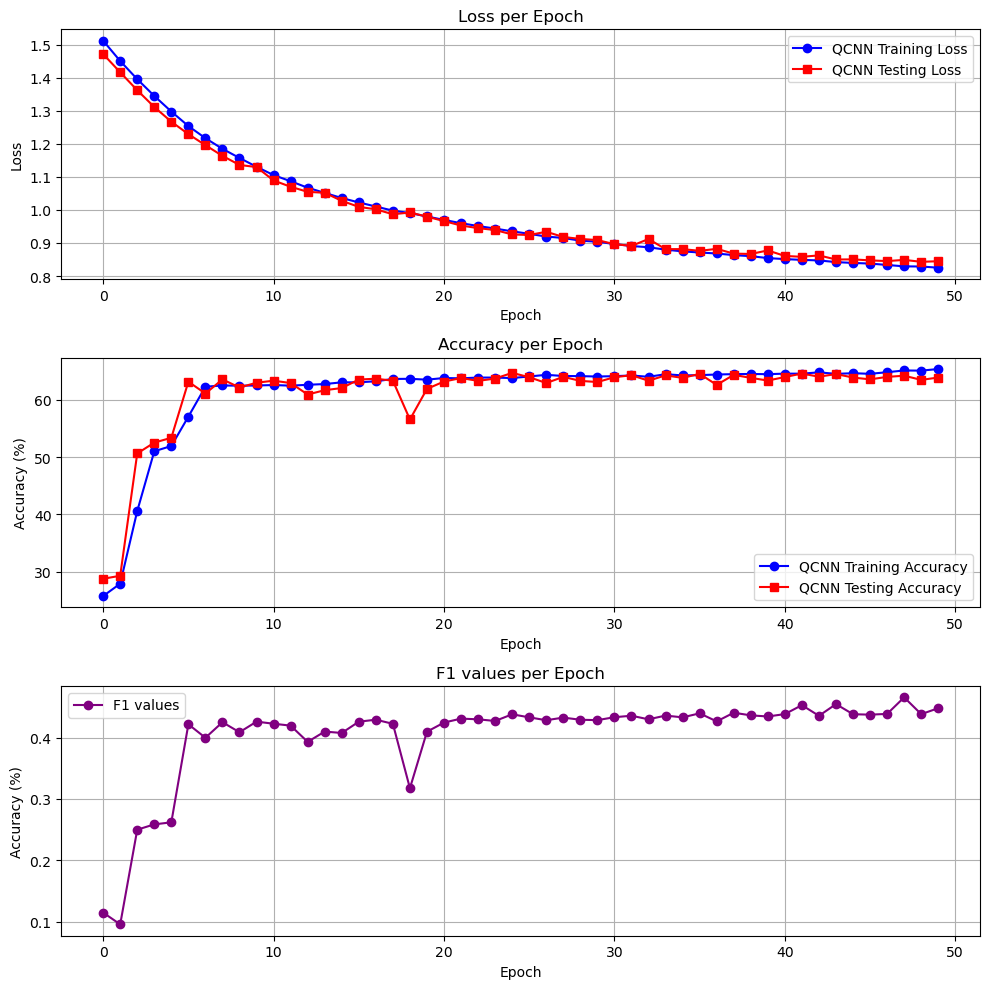

In [71]:

import matplotlib.pyplot as plt
# Plot training loss
plt.figure(figsize=(10, 10))

plt.subplot(3, 1,1)
plt.plot(train_loss_history, marker='o', label='QCNN Training Loss', color='blue')
plt.plot(test_loss_history,marker='s', label='QCNN Testing Loss', color='red')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot test accuracy
plt.subplot(3, 1, 2)
plt.plot(train_acc_history, marker= 'o', label='QCNN Training Accuracy', color= 'blue')
plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(test_f1_history, marker= 'o', label='F1 values', color= 'purple')
#plt.plot(test_acc_history,marker= 's', label= 'QCNN Testing Accuracy', color= 'red')
plt.title('F1 values per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.savefig('double_slit_qcnn_VAE.png')
plt.show()

In [100]:
inputs, _ = next(iter(trainloader_split))
input_res = tuple(inputs.shape[1:])  # drop batch dimension

macs, params = get_model_complexity_info(
    model,
    input_res,
    as_strings=True,
    print_per_layer_stat=True,
    verbose=True
)

QCNN(
  41.13 k, 99.956% Params, 41.13 KMac, 99.961% MACs, 
  (fc1): Linear(40.97 k, 99.555% Params, 40.97 KMac, 99.560% MACs, in_features=4096, out_features=10, bias=True)
  (qcnn): QuantumLayer(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  )
  (fc2): Linear(80, 0.194% Params, 80.0 Mac, 0.194% MACs, in_features=4, out_features=16, bias=True)
  (fc3): Linear(85, 0.207% Params, 85.0 Mac, 0.207% MACs, in_features=16, out_features=5, bias=True)
)
